In [9]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from utils import *
from model import * 
from matplotlib.colors import ListedColormap

In [2]:
import importlib
import utils 
importlib.reload(utils)
from utils import *

In [3]:
def convert_params(params): 
    ''' 
    lambda, gamma, mu, c, b, sigma_d, 
    '''
    c = params[3]
    gamma = params[1]
    J = np.array([[-params[0], params[2]], [-c*params[0], -gamma+c*params[2]]])
    B = np.diagflat([params[5]**2, gamma])
    Dh = B[0, 0] 
    B[1, 0] += c*Dh
    B[0, 1] = B[1, 0] 
    B[1, 1] += c*c*Dh
    return J, B 

def get_J(params):
    c = params[3]
    gamma = params[1]
    J = np.array([[-params[0], params[2]], [-c*params[0], -gamma+c*params[2]]])
    return J 
    

def flow(coor): 
    rhs = np.einsum('ij,jkl->ikl', J, coor)
    rhs[1] -= beta*coor[1]**3 
    return rhs

In [4]:
# simulation parameter 
dt = 5e-3
n_frames = 5000
T = 0.033*n_frames
n_repeats = 1

# # estimation from spinning rod + direct measurements 
gamma = 1
c =  14.4*gamma
mu = 0.1
epsilon = 0.374
beta = 14.25*gamma

params = [epsilon, gamma, mu, c, beta, 0.05]

# MLE 

# params = [0.09872, 0.42583, 0.18864, 5.78463, 12.51193, 0.02366]
# std_err = [0.02064, 0.06515, 0.02015, 0.27197, 1.24794, 0.00028]

print(params)
J, B = convert_params(params)
print('J: ', J)
print('B: ', B)
print('eigenvals: ', np.linalg.eigvals(J))


m = FHN_det(params, get_J)
det_res = m.evolve(T, n_frames, [0.1, 0])

[0.374, 1, 0.1, 14.4, 14.25, 0.05]
J:  [[-0.374   0.1   ]
 [-5.3856  0.44  ]]
B:  [[0.0025 0.036 ]
 [0.036  1.5184]]
eigenvals:  [0.033+0.61066439j 0.033-0.61066439j]


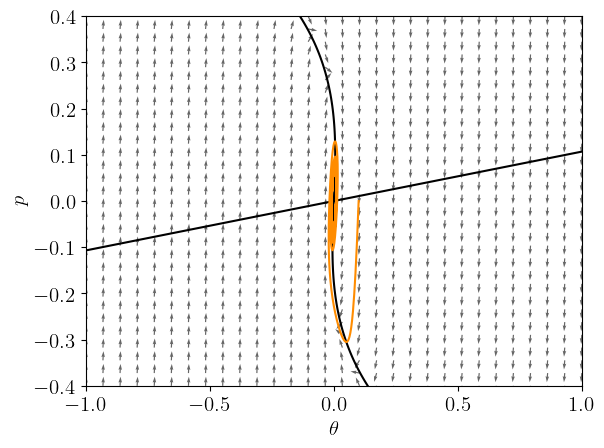

In [5]:
## Plot flow diagrams for decay regime and limit cycle  regime 
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)

gamma = params[1]
c = params[3]
mu = params[2] 
beta = params[-2]
epsilon = params[0]

xlim = 1
ylim = 0.4


x = np.linspace(-xlim, xlim, 30)
y = np.linspace(-0.4, 0.4, 30)
X, Y = np.meshgrid(x, y)
coor = np.stack([X, Y], axis=0)

x = np.linspace(-xlim, xlim, 100)
y = np.linspace(-0.4, 0.4, 100)

v = flow(coor)
v /= np.linalg.norm(v, axis=0)


plt.quiver(X, Y, v[0], v[1], alpha=0.6)
plt.plot(((-gamma + c*mu)*y - beta*y**3)/(c*epsilon), y, c='k')
plt.plot(x, mu*y/epsilon, c='k')
plt.plot(det_res[0], det_res[1], c='DarkOrange')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p$')
plt.xlim([x[0], x[-1]])
plt.ylim([y[0], y[-1]])
# plt.savefig('Figures/FHN2.pdf')
plt.show() 

In [6]:
gamma = 1
c =  14.4*gamma
mu = 0.1
epsilon = 0.374
beta = 14.25*gamma

mean = [epsilon, gamma, mu, c, beta, 0.05]
std_err = [0]*len(params)

# MLE 

# mean = [0.09872, 0.42583, 0.18864, 5.78463, 12.51193, 0.02366]
# std_err = [0.02064, 0.06515, 0.02015, 0.27197, 1.24794, 0.00028]

dt = 6.6e-3 
n_repeats = 2

results = [] 
for i in range(100):
    params = np.random.normal(mean, std_err) 
    m = FHN(params, convert_params, m_err = [0.002, 0.04])
    results.extend(m.evolve(T, dt, int(n_frames), n_repeats))

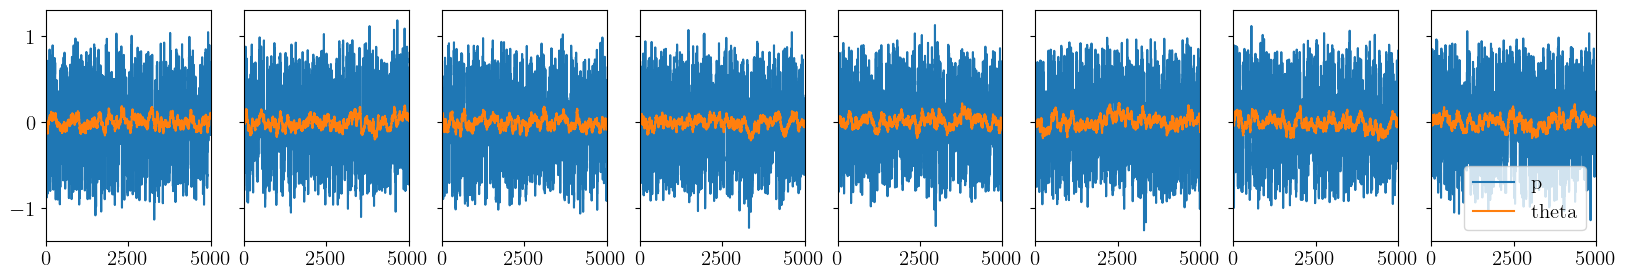

In [7]:
show(np.array(results)[::2][:8])

In [30]:
def plot_corr(data, N, dt, norm=True, tex=False, colors=['copper', 'midnightblue'], n_trajs=8):     
    t = dt*np.arange(N)
    t1 = dt*np.arange(-N+1, N)
    L = len(data[0][0])

    continuous_cmap = plt.get_cmap(colors[0])
    colorlist = continuous_cmap(np.linspace(0.3, 0.8, n_trajs))
    discrete_cmap = ListedColormap(colorlist)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), width_ratios=[3, 1, 2]) 
    
    theta_corrs = [] 
    p_corrs = [] 
    cross_corrs = [] 
    for (i, (theta, p)) in enumerate(data): 
        theta_corrs.append(find_auto_corr(theta, norm=norm))
        p_corrs.append(find_auto_corr(p, norm=norm))
        cross_corrs.append(find_corr(theta, p, norm=norm))
        if i < n_trajs:
            axes[0].plot(t, theta_corrs[-1][:N], alpha=0.6, c=discrete_cmap(i))
            axes[1].plot(t, p_corrs[-1][:N], alpha=0.6, c=discrete_cmap(i))
            axes[2].plot(t1, cross_corrs[-1][L-N+1:L+N], alpha=0.6, c=discrete_cmap(i))
        
    axes[0].plot(t, np.mean(theta_corrs, axis=0)[:N], '--', c=colors[1])
    axes[1].plot(t, np.mean(p_corrs, axis=0)[:N], '--', c=colors[1])
    axes[2].plot(t1, np.mean(cross_corrs, axis=0)[L-N+1:L+N], '--', c=colors[1])
    axes[0].set_xlim([0, 50])
    axes[1].set_xlim([0, 10])
    axes[2].set_xlim([-50, 50])
    axes[0].set_ylabel(r'$\theta$ autocorrelation')
    axes[0].set_xlabel(r'$t$')
    axes[1].set_ylabel(r'$p$ autocorrelation')
    axes[1].set_xlabel(r'$t$')
    axes[2].set_ylabel(r'cross-correlation')
    axes[2].set_xlabel(r'$t$')
    plt.tight_layout()
    return theta_corrs, p_corrs, cross_corrs 

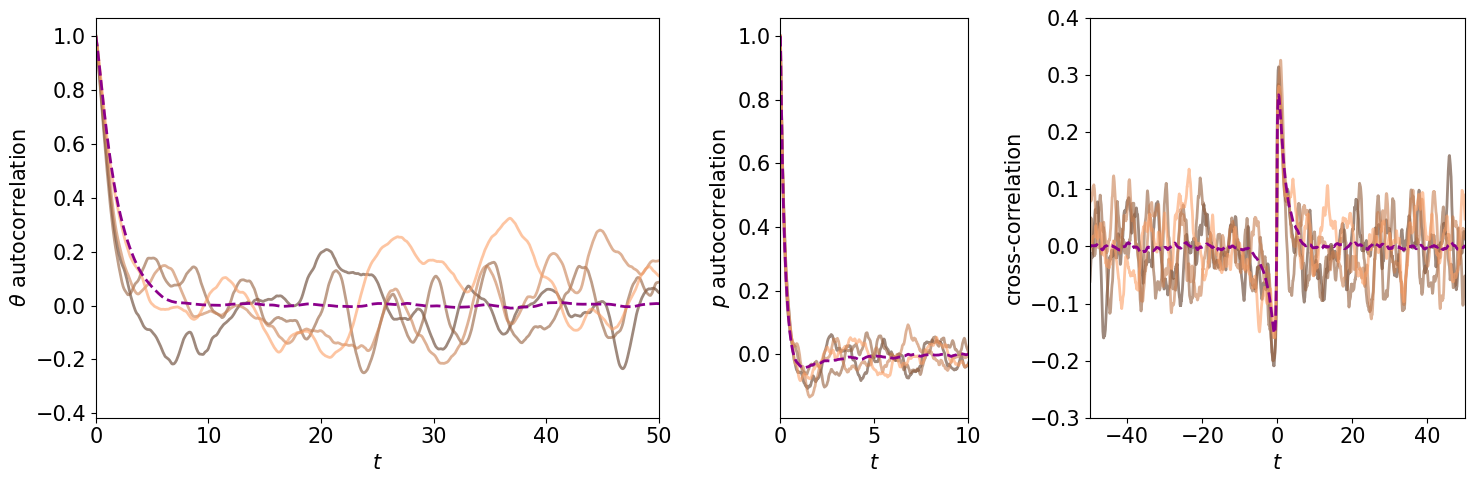

In [31]:
plt.rcParams.update({'lines.linewidth': 2})
plt.rc('text', usetex=False)
plt.rc('font', family='sans serif', size=15)
_, _, _= plot_corr(results[:100], 3000, 3.3e-2, tex=True, n_trajs=4, colors=['copper', 'darkmagenta'])
plt.ylim([-0.3, 0.4])
plt.savefig('Figures/guess_coor.pdf')
plt.show() 

In [43]:
def plot_overall_dist(data, tex=False, color='darkorange', cmap='Greys'): 
    plt.rc('text', usetex=tex)
    plt.rc('font', family='sans serif', size=20)
    
    thetas = np.concatenate([d[0] for d in data])
    ps = np.concatenate([d[1] for d in data])

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    _, _, _, im = axes[2].hist2d(thetas, ps, density=True, cmap=cmap, bins=30)
    axes[2].set_xlabel(r'$\theta$')
    axes[2].set_ylabel(r'$p$')

    axes[1].hist(ps, bins=40, density=True, color=color, alpha=0.8)
    axes[1].set_xlim([-1, 1])
    axes[1].set_xlabel(r'$p$')
    axes[1].set_ylabel(r'$P(p)$')
    
    axes[0].hist(thetas, bins=40, density=True, color=color, alpha=0.8)
    axes[0].set_xlim([-0.5, 0.5])
    axes[0].set_xlabel(r'$\theta$')
    axes[0].set_ylabel(r'$P(\theta)$')
    cbar = plt.colorbar(im, ax=axes[2])
    cbar.set_label(r'$P(\theta, p)$', rotation=90)
    plt.tight_layout()
    return fig, axes 


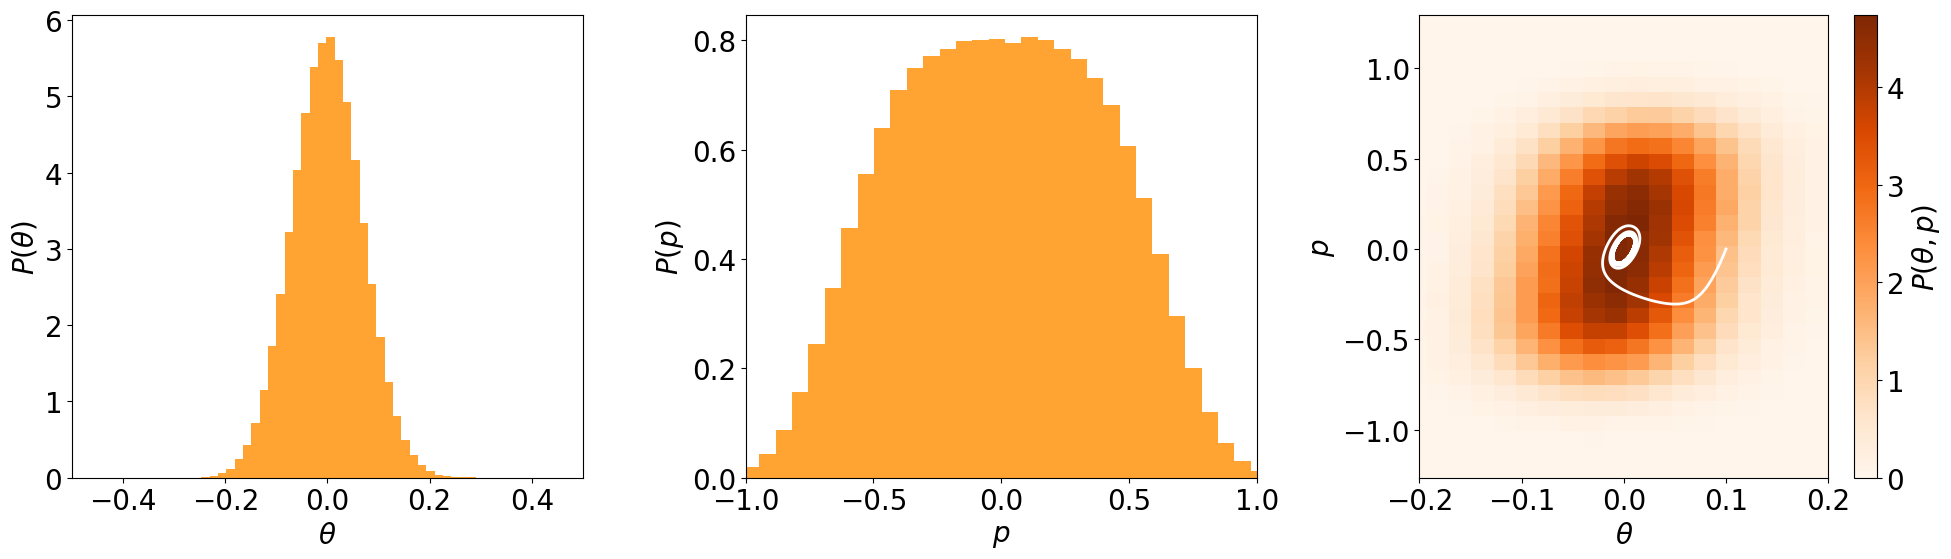

In [44]:
fig, axes = plot_overall_dist(results, tex=False, cmap='Oranges')
axes[2].plot(det_res[0], det_res[1], color='white', linewidth=2)
axes[2].set_xlim([-0.2, 0.2])
plt.savefig('Figures/guess_dist.pdf')
plt.show() 

In [10]:
def plot_corr2(data, N, dt, label, c, norm=True): 
    
    t = dt*np.arange(N)
    t1 = dt*np.arange(-N+1, N)
    L = len(data[0][0])
    
    cross_corrs = [] 
    
    for (theta, p) in data: 
        cross_corrs.append(find_corr(theta, p, norm=norm))

    plt.plot(t1, np.mean(cross_corrs, axis=0)[L-N+1:L+N], label=label, color=c)

In [11]:
collected_results = [] 

cs = [0, 0.1, 1, 14.4, 100]
for temp in cs: 
    
    params = [epsilon, gamma, mu, temp, beta, 0.044]

    n_repeats = 8
    print(params)
    m = FHN(params, convert_params)
    collected_results.append(m.evolve(T, dt, int(n_frames), n_repeats))

[0.374, 1, 0.1, 0, 14.25, 0.044]
[0.374, 1, 0.1, 0.1, 14.25, 0.044]
[0.374, 1, 0.1, 1, 14.25, 0.044]
[0.374, 1, 0.1, 14.4, 14.25, 0.044]
[0.374, 1, 0.1, 100, 14.25, 0.044]


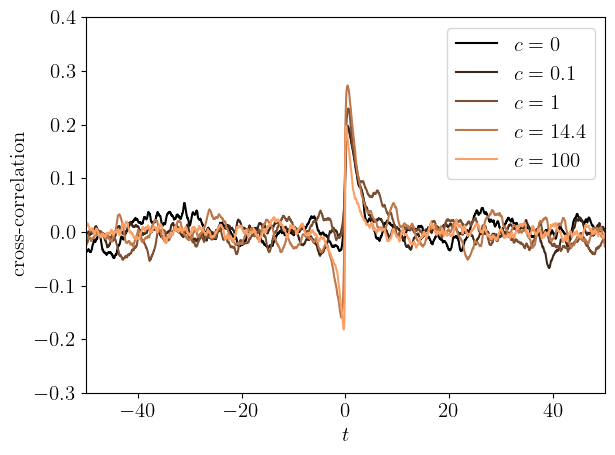

In [12]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)

cmap = plt.colormaps['copper']

for (i, (temp, results)) in enumerate(zip(cs, collected_results)): 
    plot_corr2(results, 3000, 3.3e-2, r'$c = {{{}}}$'.format(temp), c=cmap(i/5))

    
plt.ylabel(r'cross-correlation')
plt.xlabel(r'$t$')
plt.xlim([-50, 50])
plt.ylim([-0.3, 0.4])
plt.legend() 
plt.tight_layout()
plt.savefig('Figures/c_variations.pdf')
plt.show() 

In [13]:
collected_results = [] 

mus = [0, 1e-2, 0.1, 1, 10]
for temp in mus: 
    
    params = [epsilon, gamma, temp, c, beta, 0.044]

    n_repeats = 8
    print(params)
    m = FHN(params, convert_params)
    collected_results.append(m.evolve(T, dt, int(n_frames), n_repeats))

[0.374, 1, 0, 14.4, 14.25, 0.044]
[0.374, 1, 0.01, 14.4, 14.25, 0.044]
[0.374, 1, 0.1, 14.4, 14.25, 0.044]
[0.374, 1, 1, 14.4, 14.25, 0.044]
[0.374, 1, 10, 14.4, 14.25, 0.044]


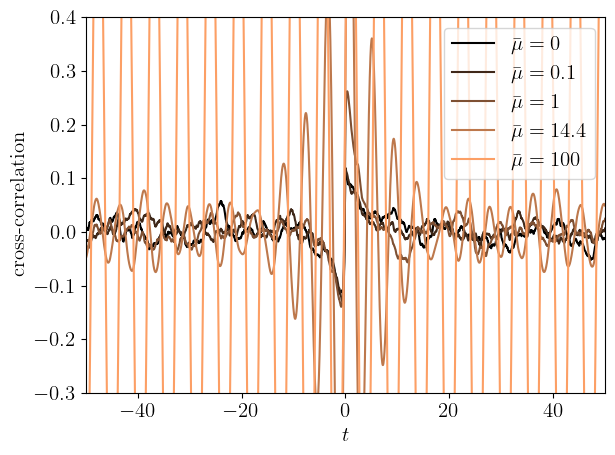

In [14]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)

cmap = plt.colormaps['copper']

for (i, (temp, results)) in enumerate(zip(cs, collected_results)): 
    plot_corr2(results, 3000, 3.3e-2, r'$\bar{{\mu}} = {{{}}}$'.format(temp), c=cmap(i/5))

plt.ylabel(r'cross-correlation')
plt.xlabel(r'$t$')
plt.xlim([-50, 50])
plt.ylim([-0.3, 0.4])
plt.legend() 
plt.tight_layout()
plt.savefig('Figures/mu_variations.pdf')
plt.show() 